In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 100,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 80,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 5,
    'ETA': 1,
}

In [3]:
DATA_DIR = '../data'
adata_healthy = sc.read(
    f'{DATA_DIR}/haniffa_healthy_obsmProt.h5ad'
)
adata_disease = sc.read(
    f'{DATA_DIR}/haniffa_disease_obsmProt.h5ad'
)
adata = adata_healthy.concatenate(adata_disease)

In [4]:
pd.crosstab(adata.obs['patient_id'], adata.obs['initial_clustering'])

initial_clustering  B_cell   CD4   CD8  CD14  CD16  DCs  HSC  Lymph_prolif  \
patient_id                                                                   
AP1                    142  2165   518   655    94   27   24            32   
AP10                   388  1812   636    64    16    4    5            21   
AP11                   522  2353  1460  4467   714  119   17            43   
AP12                  1117  1908  1352  1140    77    5   13            22   
AP2                    149  3276   523   256    77    5   12            16   
...                    ...   ...   ...   ...   ...  ...  ...           ...   
newcastle21v2           38  1595   861  1998   412   86   34            47   
newcastle49            151  1726   523  2937   677  105  527            88   
newcastle59            126   274   697  2290   622   26   23            24   
newcastle65            131  2383  1221   399   240   92    7            31   
newcastle74            531   910  2423   572   263  124   21            23   

initial_clustering  MAIT  Mono_prolif  NK_16hi  NK_56hi  Plasmablast  \
patient_id                                                             
AP1                   22            0      444       36           67   
AP10                  68            0      190       35          156   
AP11                  76            1      614       87           88   
AP12                 138            1     2154      228           31   
AP2                   29            0      105       26           11   
...                  ...          ...      ...      ...          ...   
newcastle21v2         46            0     1483       93           18   
newcastle49           38           92      324       94           42   
newcastle59           55            2      534      122           21   
newcastle65          119            0      552      100            4   
newcastle74          147            0     1402      105            9   

initial_clustering  Platelets  RBC  Treg  gdT  pDC  
patient_id                                          
AP1                        36   24   173   29    6  
AP10                       28   18   162    8    5  
AP11                       95    4   219   27   15  
AP12                      109   36   188   50    5  
AP2                        36    2   214   23    0  
...                       ...  ...   ...  ...  ...  
newcastle21v2             260    0   179   97   53  
newcastle49               250    6   179   98  375  
newcastle59                71    1    43   29  136  
newcastle65                34    1   181  121   39  
newcastle74                55    0    87  218   42  

[130 rows x 18 columns]

In [5]:
condition_key = 'patient_id'
cell_type_key = ["initial_clustering"]
adata = adata[adata.obs[cell_type_key[0]] != 'Mono_prolif']
patients = pd.Series(adata.obs.patient_id.unique())
reference = patients[~patients.str.contains('newcastle')]
query = patients[~patients.isin(reference)]
adata.obs['query'] = adata.obs[condition_key].isin(query).astype('category')

Trying to set attribute `.obs` of view, copying.


In [6]:
adata_tmp = adata.copy()
sc.pp.normalize_total(adata_tmp)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=4000)
adata.var = adata_tmp.var
adata = adata[:, adata.var['highly_variable']]
source_adata = adata[adata.obs[condition_key].isin(reference)].copy()
target_adata = adata[adata.obs[condition_key].isin(query)].copy()

In [7]:
query

0        newcastle65
10       newcastle74
34       newcastle20
46       newcastle21
53       newcastle59
56       newcastle49
62     newcastle21v2
65    newcastle004v2
dtype: object

In [8]:
source_adata

AnnData object with n_obs × n_vars = 597827 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'protein_expression'

In [9]:
target_adata

AnnData object with n_obs × n_vars = 48892 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'protein_expression'

In [10]:
lataq_model = EMBEDCVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)

Embedding dictionary:
 	Num conditions: 122
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
lataq_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

 |████████████████████| 100.0%  - val_loss: 519.3733309884 - val_trvae_loss: 517.5538850442 - val_landmark_loss: 1.8194468463 - val_labeled_loss: 1.8194468463
Saving best state of network...
Best State was in Epoch 99


In [12]:
lataq_model.save('tmp/', overwrite=True)

In [10]:
lataq_query = EMBEDCVAE.load_query_data(
    adata=target_adata,
    reference_model='haniffa/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 48892 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'protein_expression'
Embedding dictionary:
 	Num conditions: 130
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidd

In [11]:
lataq_query.train(
    n_epochs=PARAMS['EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    eta=PARAMS['ETA'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

 |████████████████----| 80.0%  - val_loss: 685.0984857021 - val_trvae_loss: 685.0984857021
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 30 clusters.
 |████████████████████| 100.0%  - val_loss: 683.5446307843 - val_trvae_loss: 683.5445087139 - val_landmark_loss: 0.0001069436 - val_unlabeled_loss: 0.1069436425
Saving best state of network...
Best State was in Epoch 85


/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


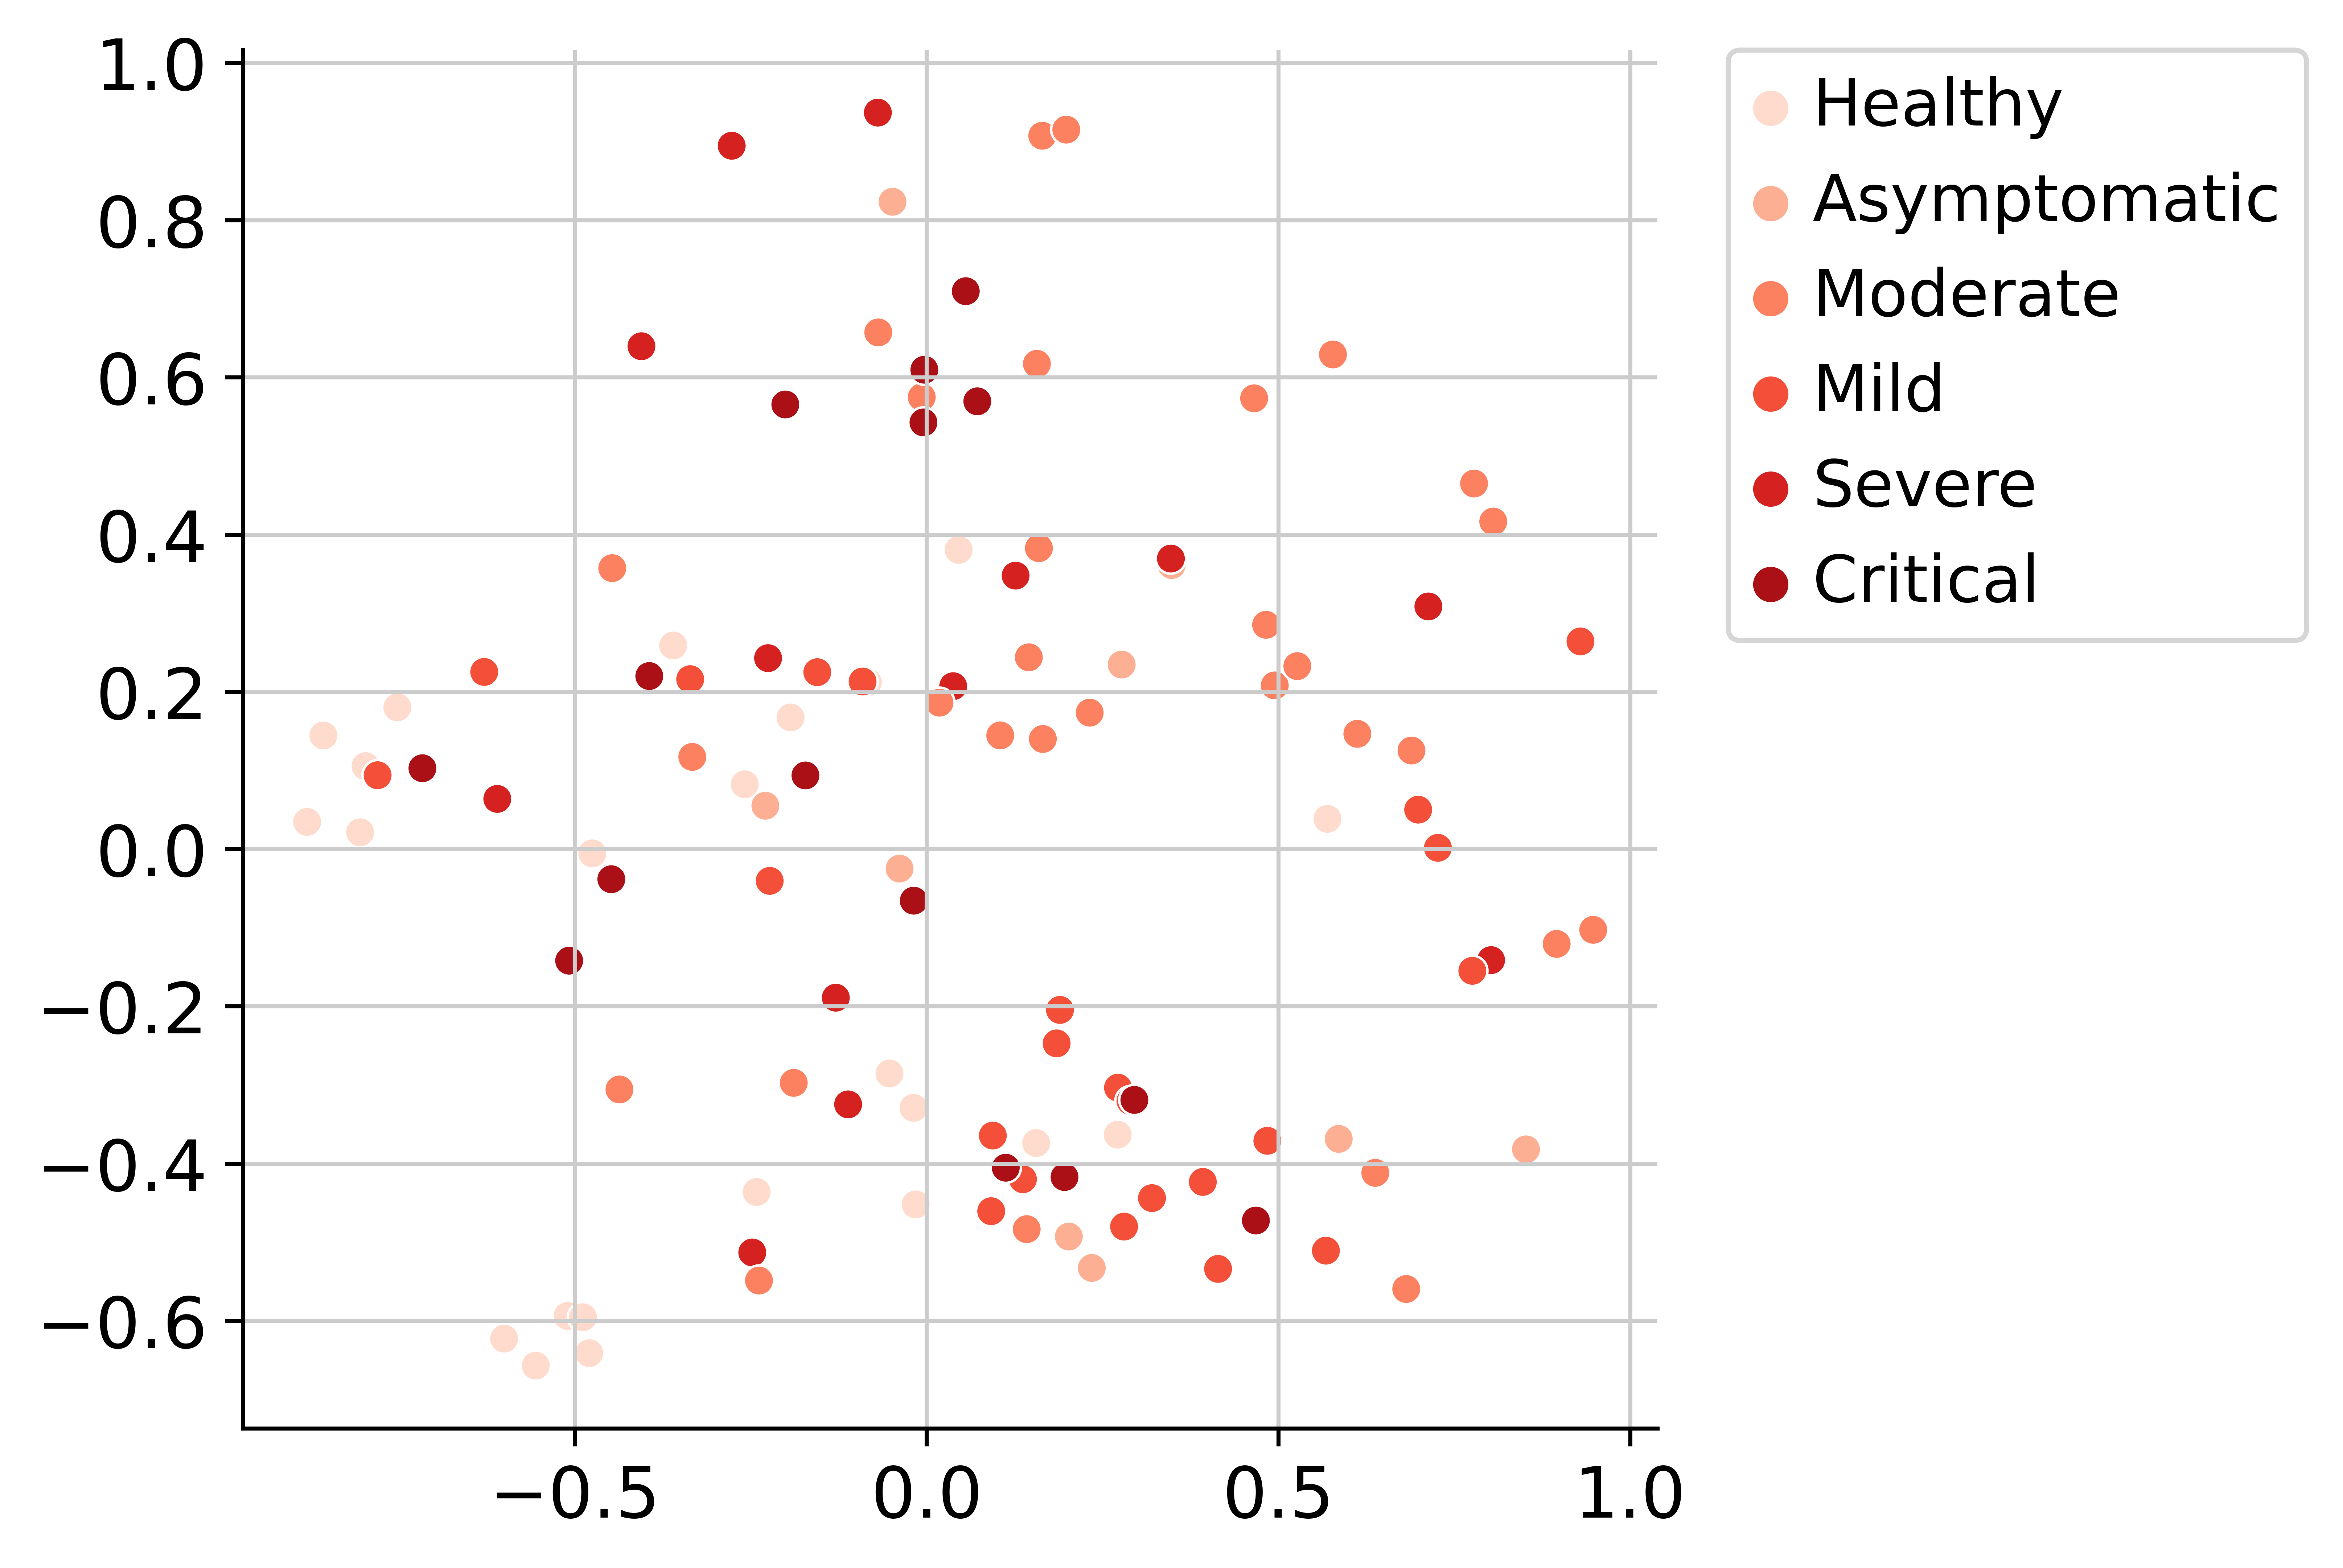

In [12]:
from sklearn.decomposition import KernelPCA

plot_key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 1], 
    emb_pca[:, 2], 
    cond,
    hue_order = cond_to_keep,
    palette = 'Reds',
    ax=ax
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for i, c in enumerate(source_adata.obs[condition_key].unique()):
    #ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    #ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


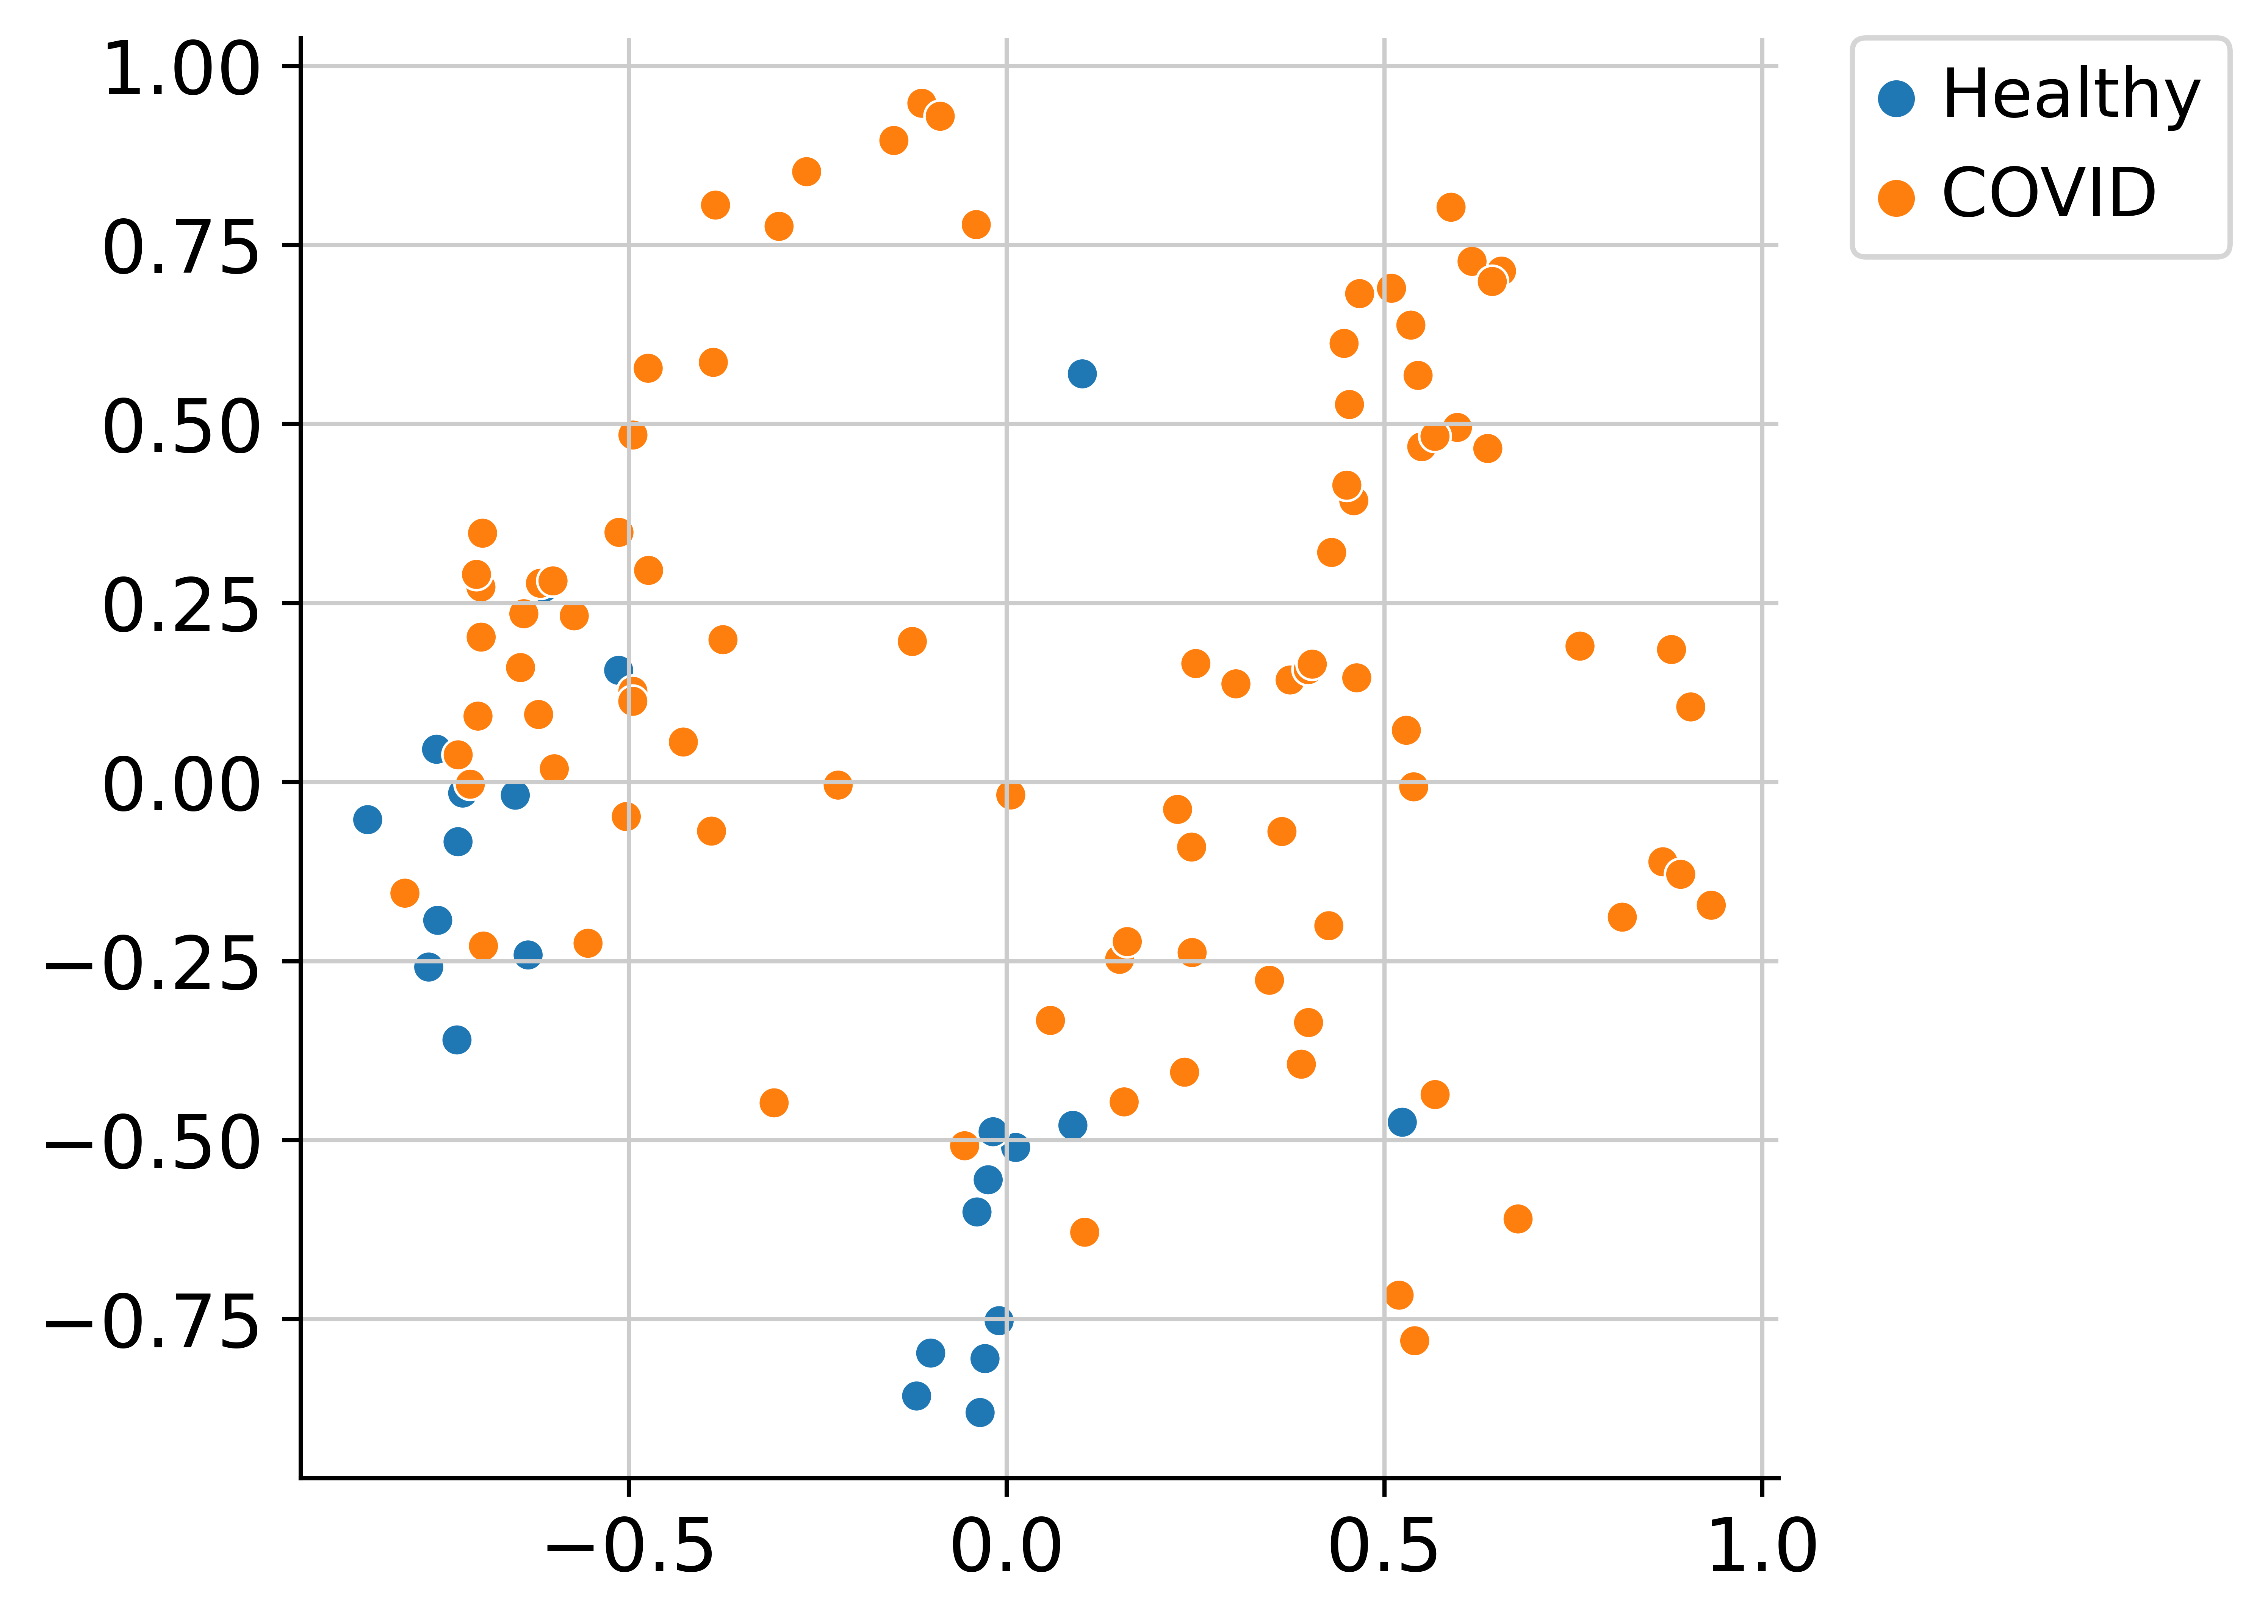

In [16]:
from sklearn.decomposition import KernelPCA

plot_key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)]
cond[cond!='Healthy'] = 'COVID'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    ax=ax
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for i, c in enumerate(source_adata.obs[condition_key].unique()):
    #ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    #ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


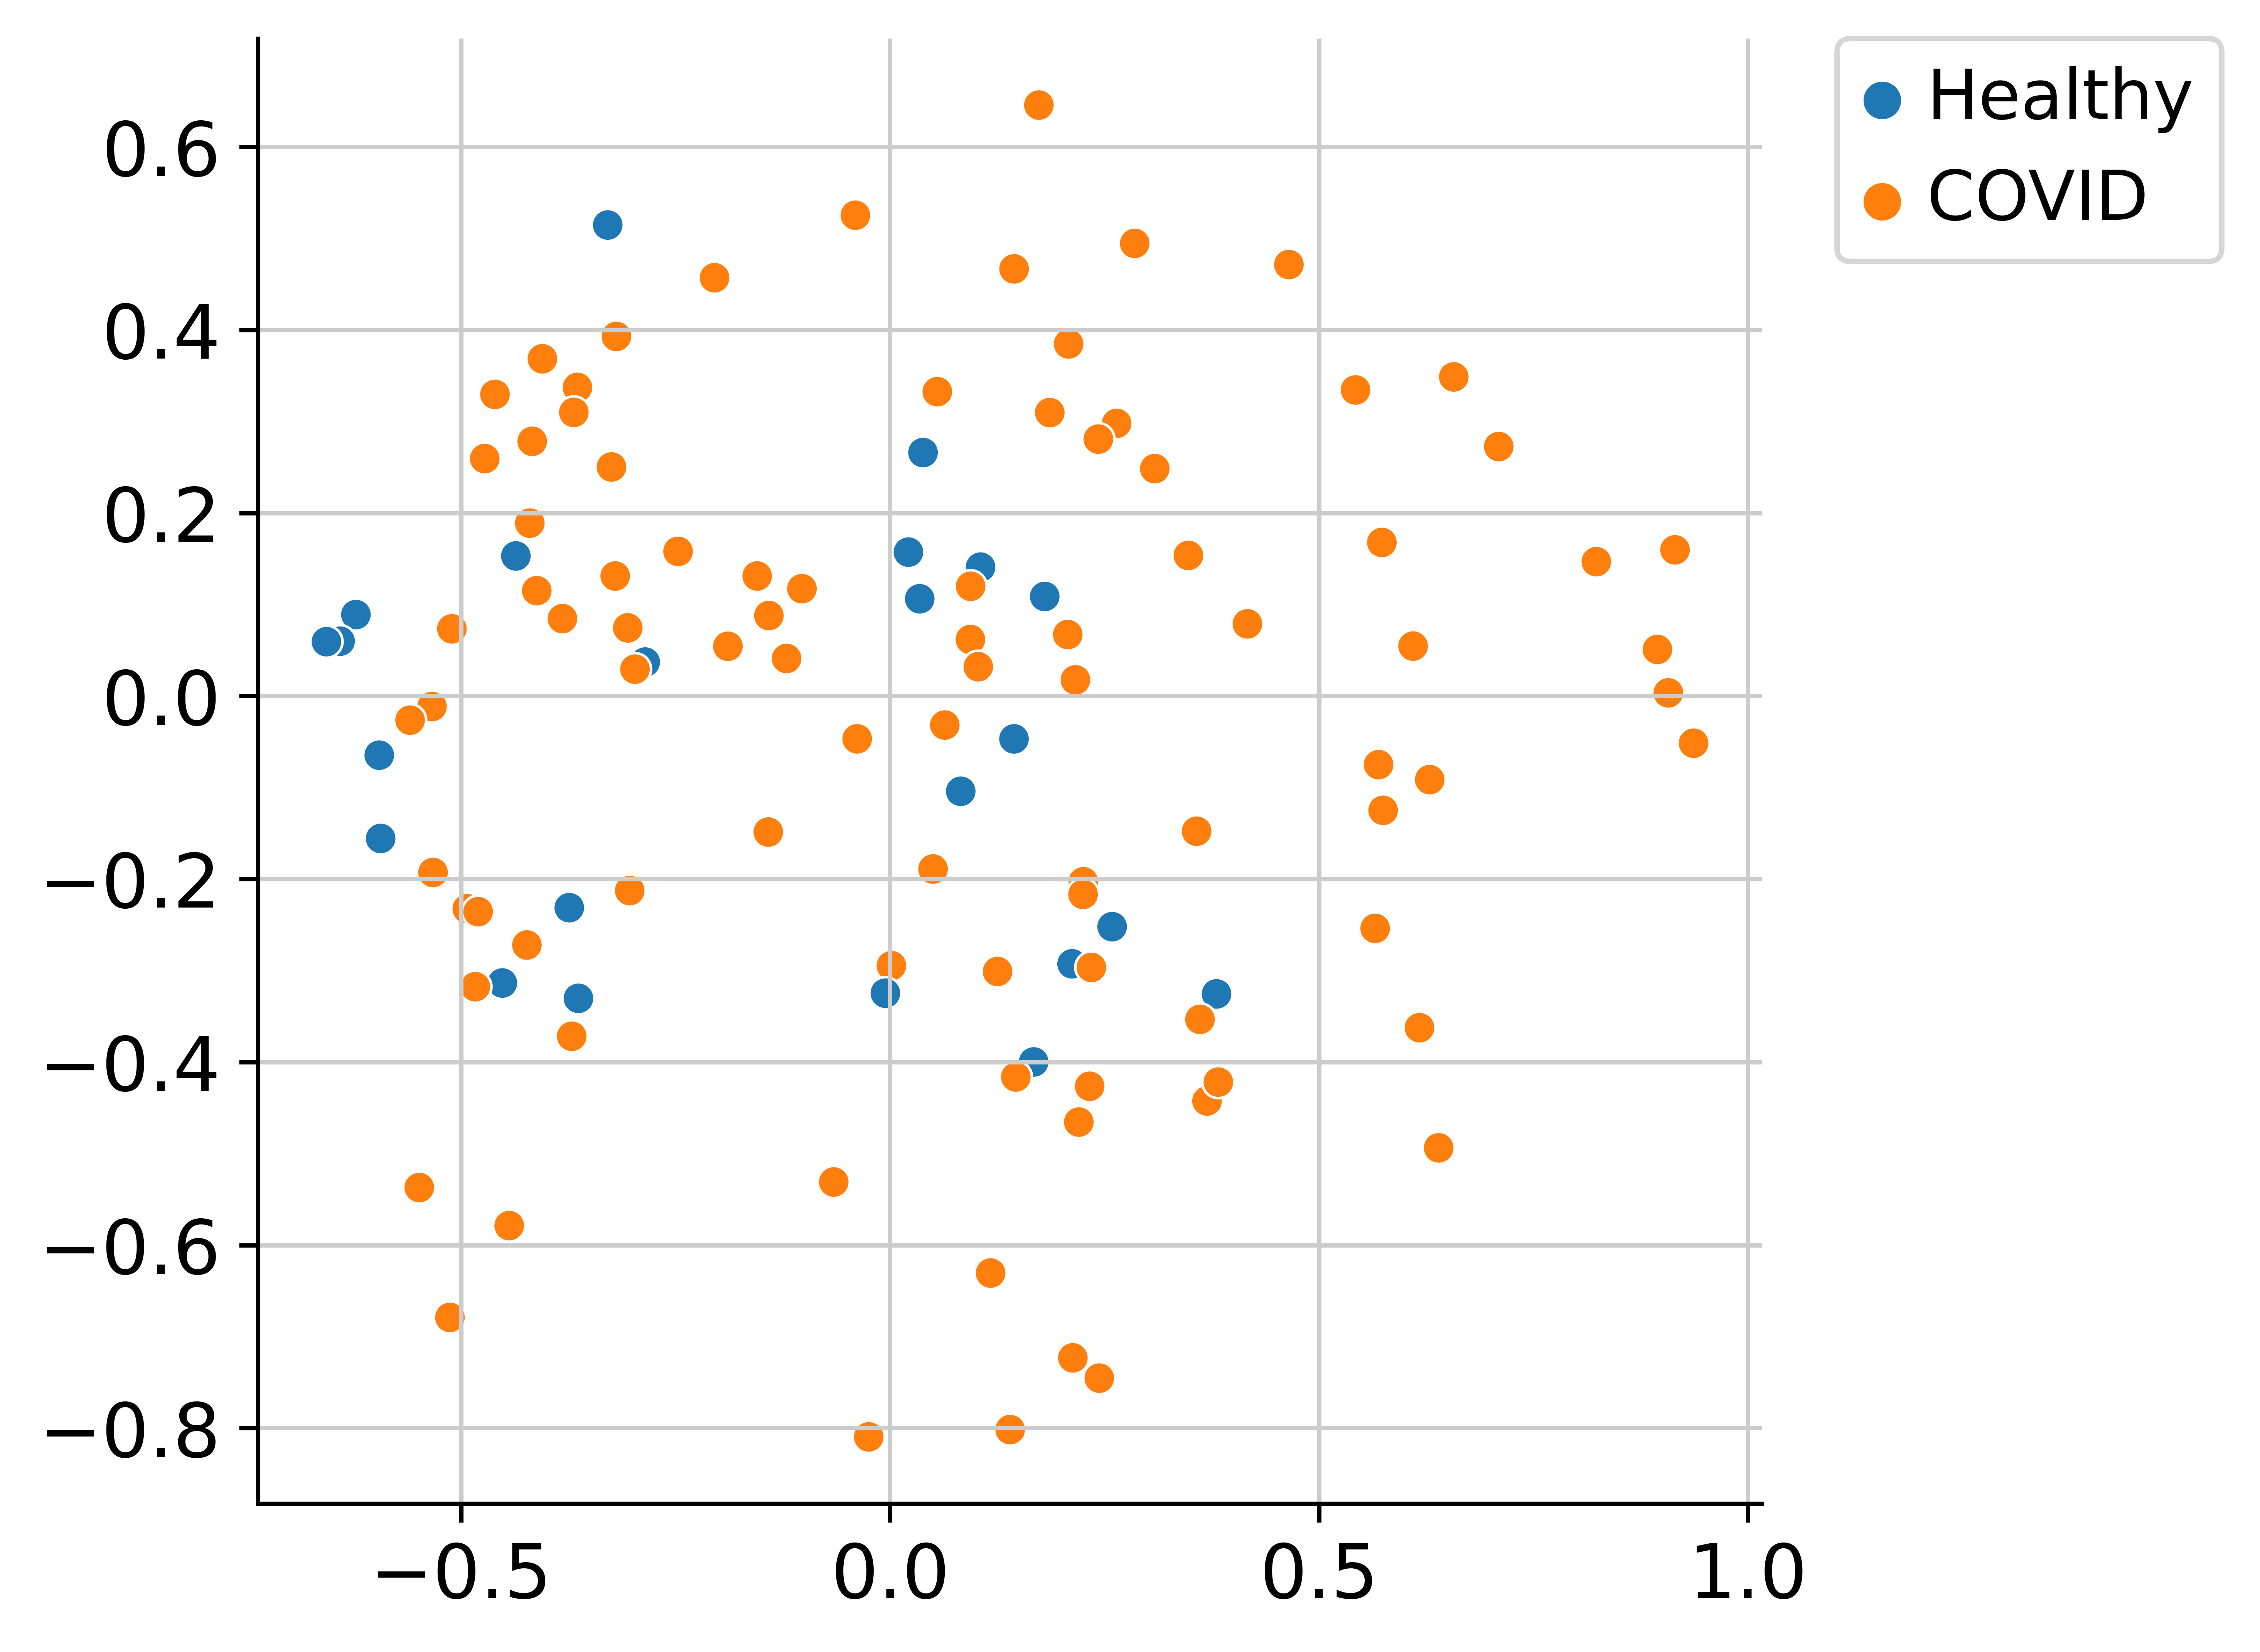

In [17]:
from sklearn.decomposition import KernelPCA

plot_key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)]
cond[cond!='Healthy'] = 'COVID'
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 2], 
    emb_pca[:, 3], 
    cond,
    ax=ax
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for i, c in enumerate(source_adata.obs[condition_key].unique()):
    #ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    #ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

In [14]:
adata.obs.columns

Index(['sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'full_clustering',
       'initial_clustering', 'Resample', 'Collection_Day', 'Sex',
       'Age_interval', 'Swab_result', 'Status', 'Smoker',
       'Status_on_day_collection', 'Status_on_day_collection_summary',
       'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status',
       'Outcome', 'patient_id', 'batch', 'query'],
      dtype='object')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


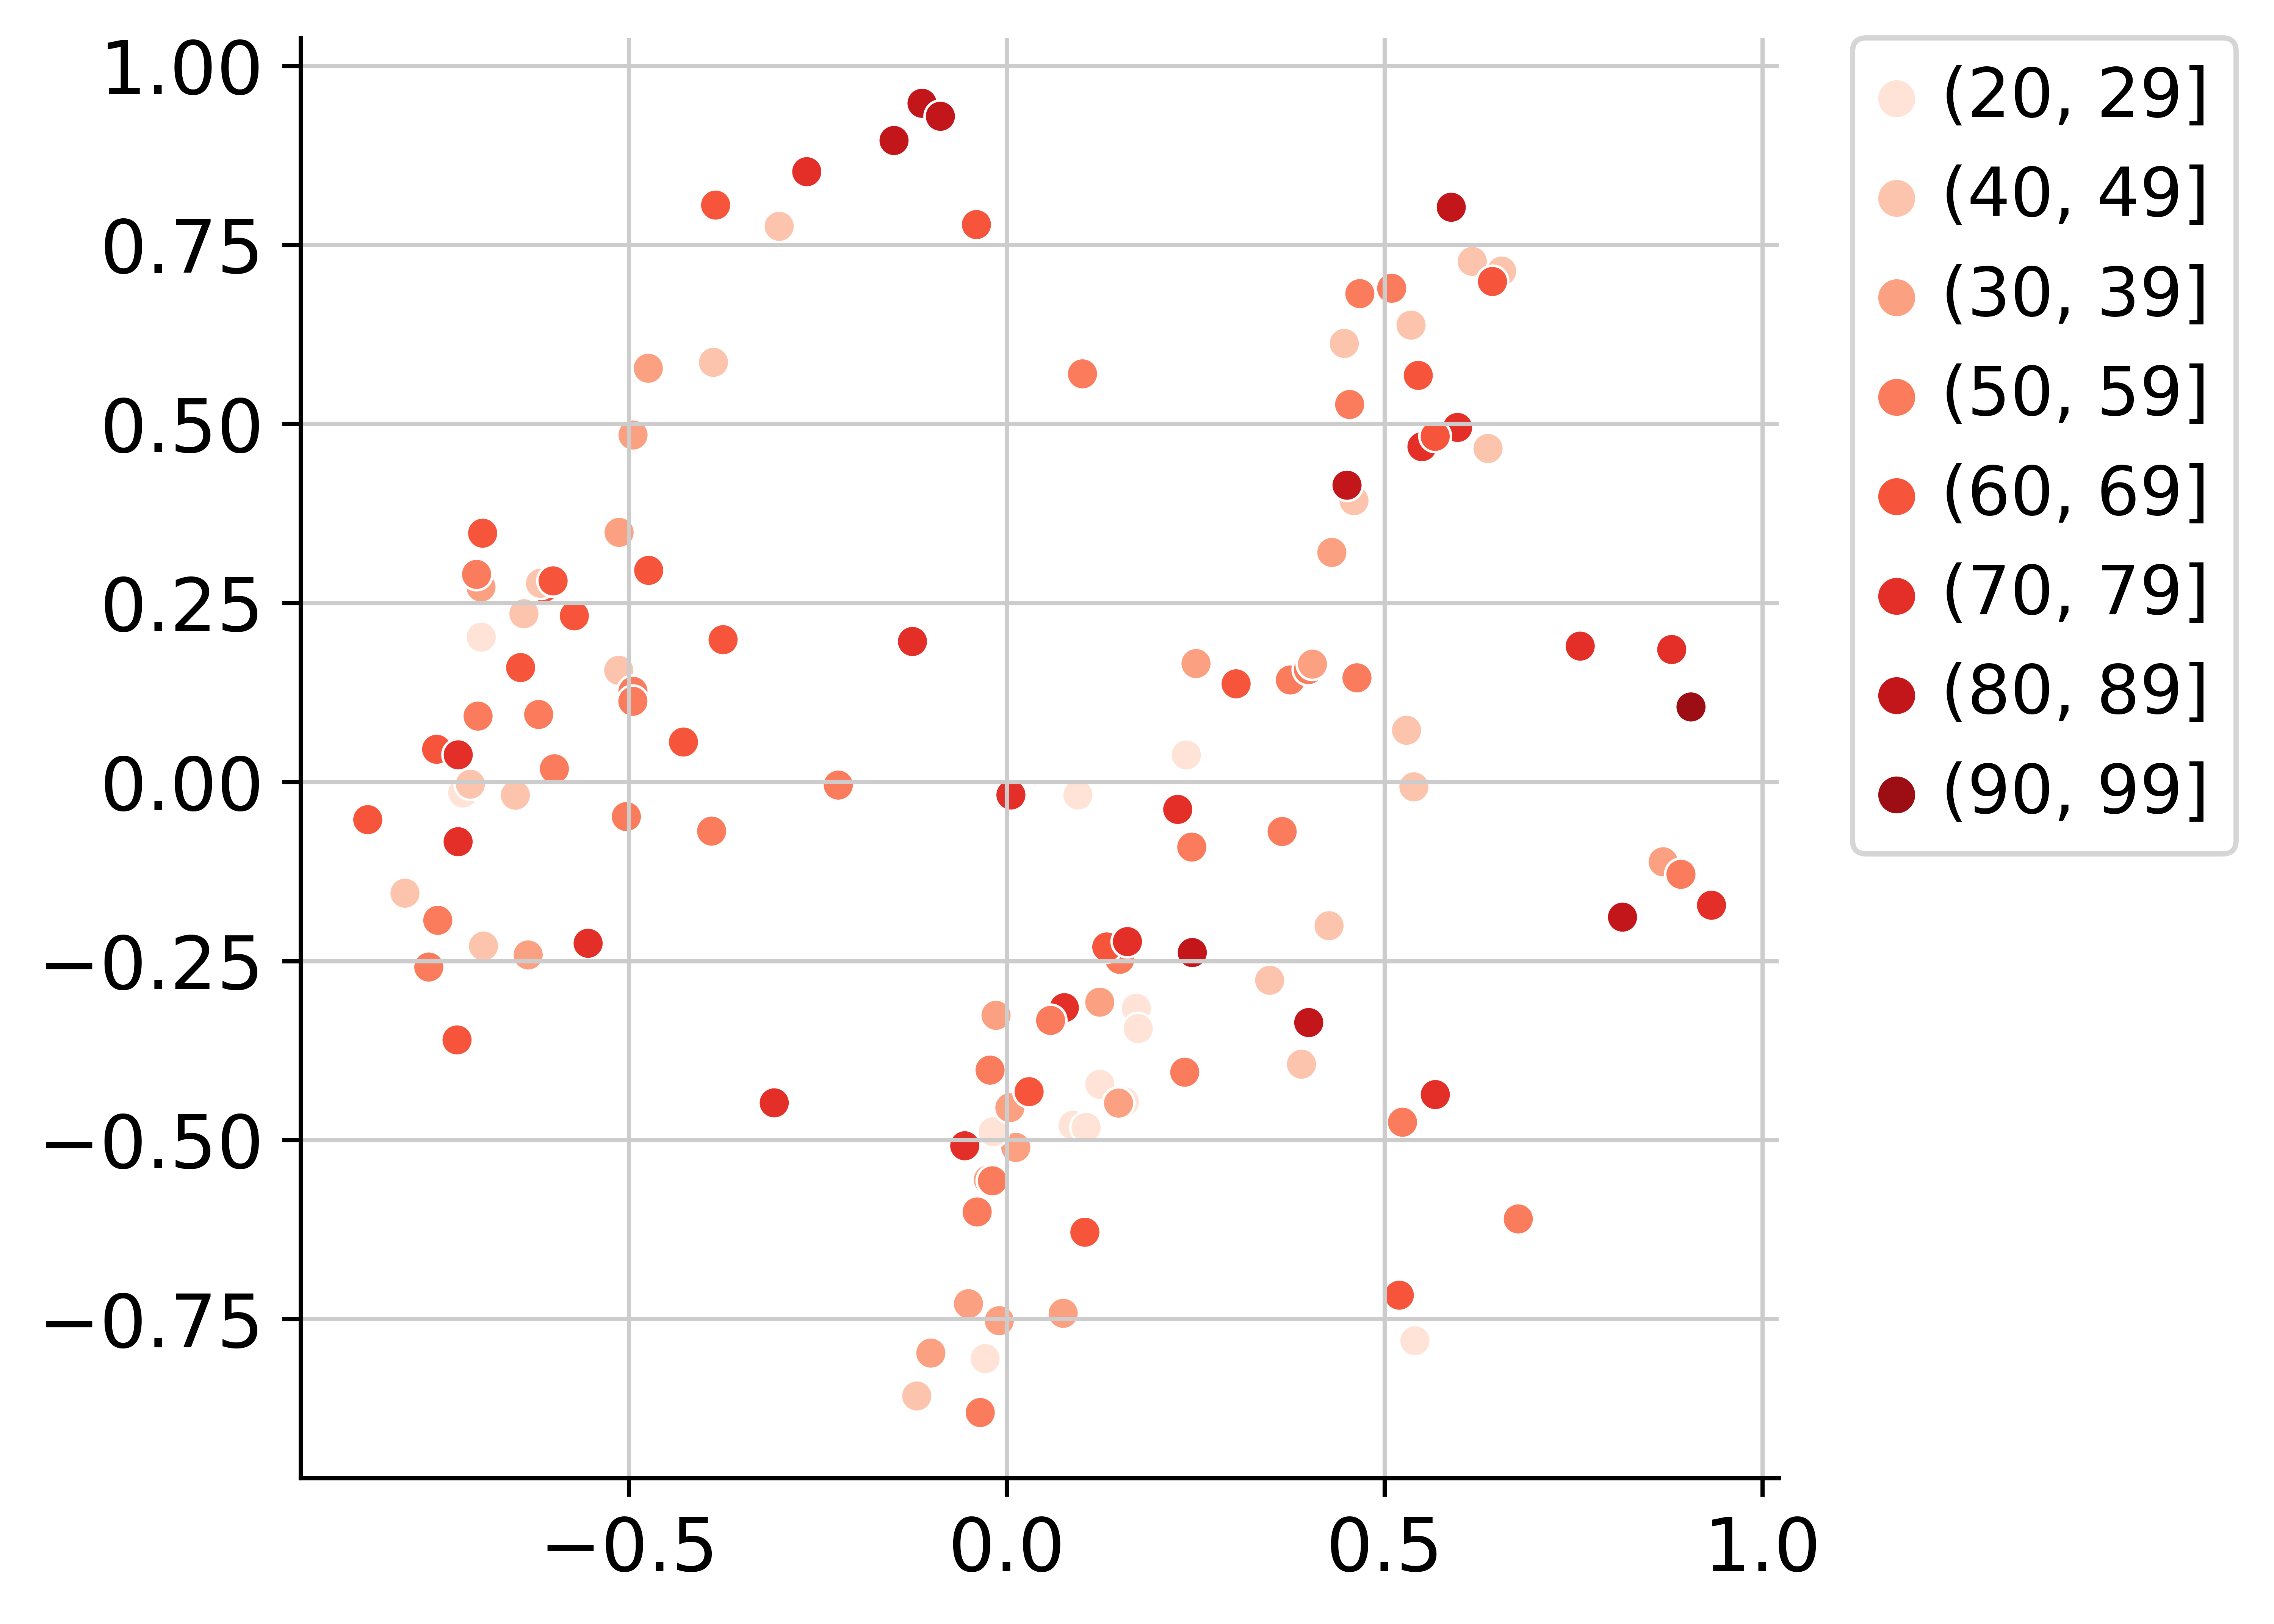

In [16]:
from sklearn.decomposition import KernelPCA

plot_key = 'Age_interval'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    ax=ax,
    palette='Reds'
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for i, c in enumerate(source_adata.obs[condition_key].unique()):
    #ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    #ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


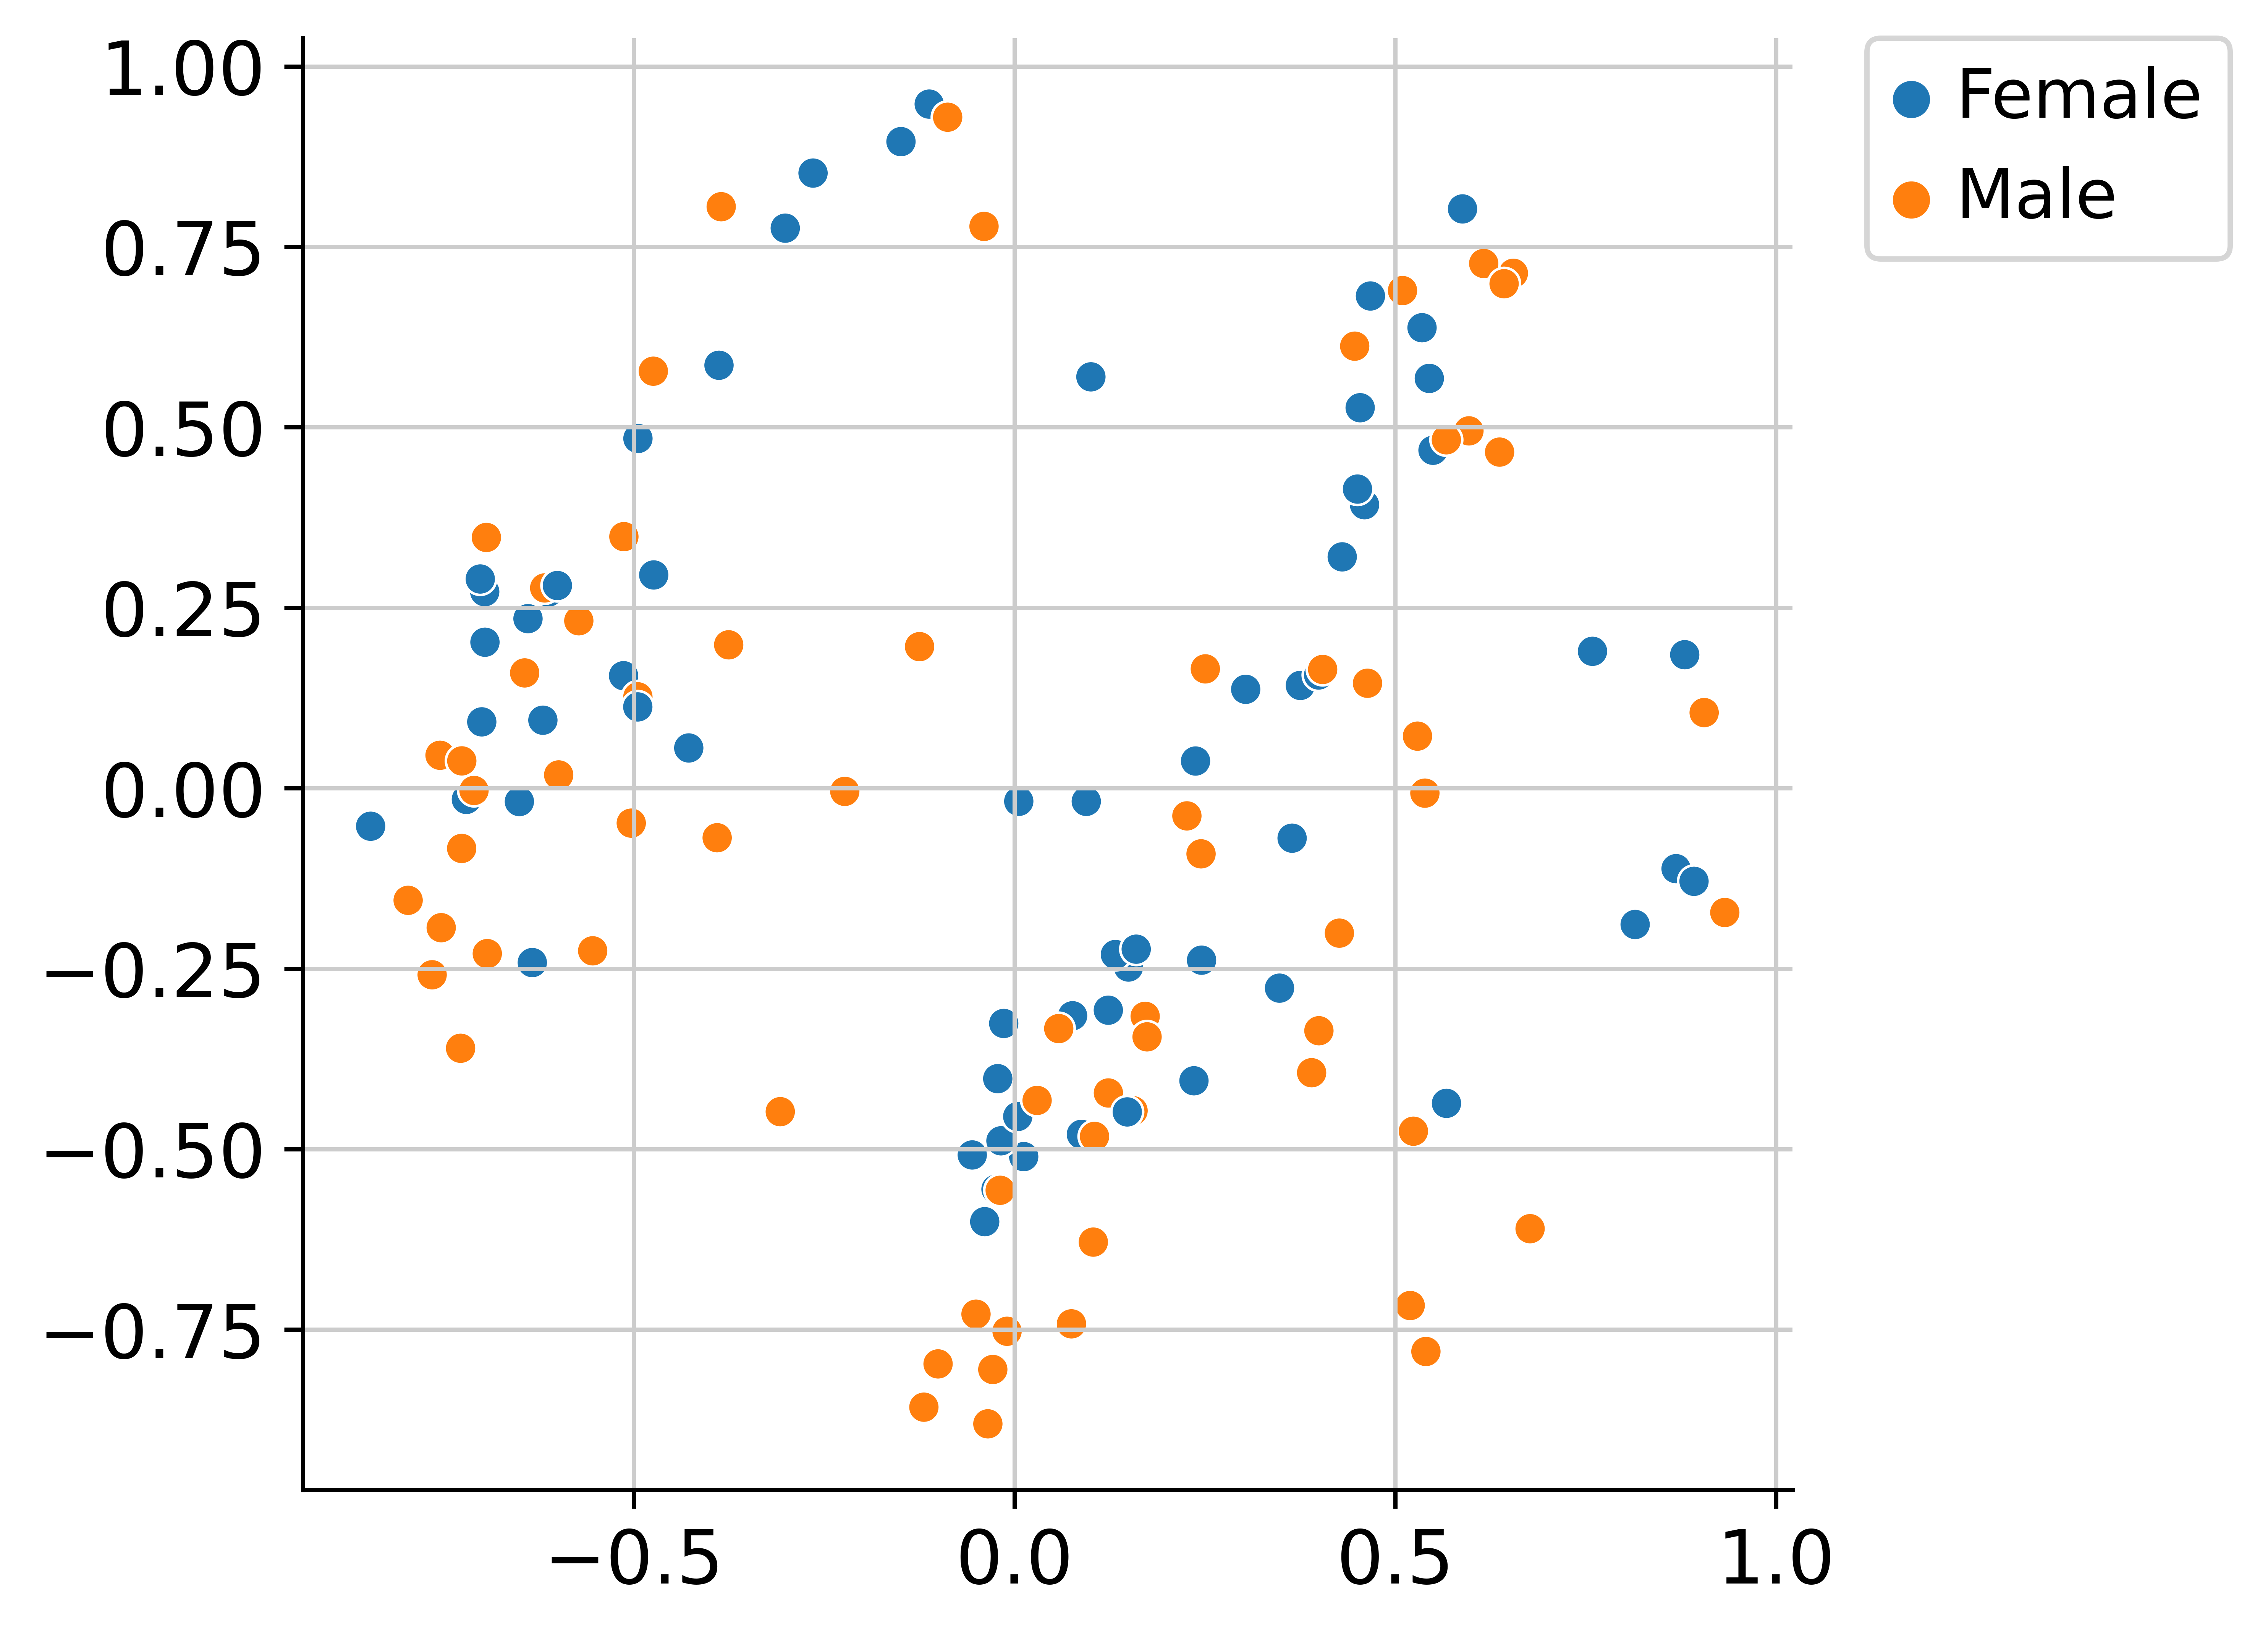

In [17]:
from sklearn.decomposition import KernelPCA

plot_key = 'Sex'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [plot_key]
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    ax=ax,
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#for i, c in enumerate(source_adata.obs[condition_key].unique()):
    #ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    #ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
embedding = pd.DataFrame(
    lataq_query
    .model
    .embedding
    .weight
    .detach()
    .cpu()
    .numpy()
)
embedding.index = lataq_query.conditions_
col = (        
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    ['Site']
)

lut = dict(zip(col.unique(), "rbg"))
row_colors = col.map(lut)

sns.clustermap(
    embedding, 
    row_colors=row_colors,
    metric='cosine',
    vmin=-1,
    vmax=1,
)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [24]:
key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)
cond_to_keep = ['Healthy', "Asymptomatic", "Moderate", "Mild", "Severe", "Critical"]
emb_pca = emb_pca[cond.isin(cond_to_keep), :]
cond = cond[cond.isin(cond_to_keep)]
cond[cond!='Healthy'] = 'COVID'

X = emb_pca
y = cond
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
neigh = SVC()
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))
y_pred = neigh.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred
    )
)

KeyError: 'Status_on_day_collection_summary'

In [26]:
adata.obs

sample_id  n_genes  n_genes_by_counts  \
covid_index                                                                 
AAACCTGAGACCACGA-newcastle65-0    newcastle65     1351               1351   
AAACCTGAGATGTCGG-newcastle65-0    newcastle65     1921               1921   
AAACCTGAGGCGATAC-newcastle65-0    newcastle65     1056               1056   
AAACCTGAGTACACCT-newcastle65-0    newcastle65     2140               2140   
AAACCTGAGTGAATTG-newcastle65-0    newcastle65     1620               1620   
...                                       ...      ...                ...   
BGCV15_TTTGGTTGTTGGGACA-1-1     BGCV15_CV0176     1631               1631   
BGCV15_TTTGTCAAGGCGATAC-1-1     BGCV15_CV0176     2401               2401   
BGCV15_TTTGTCACAGACACTT-1-1     BGCV15_CV0257     1209               1209   
BGCV15_TTTGTCAGTTACGGAG-1-1     BGCV15_CV0257     1175               1175   
BGCV15_TTTGTCATCGAATGGG-1-1     BGCV15_CV0176     1798               1798   

                                total_counts  total_counts_mt  pct_counts_mt  \
covid_index                                                                    
AAACCTGAGACCACGA-newcastle65-0        4278.0            178.0       4.160823   
AAACCTGAGATGTCGG-newcastle65-0        4740.0            127.0       2.679325   
AAACCTGAGGCGATAC-newcastle65-0        2875.0            198.0       6.886957   
AAACCTGAGTACACCT-newcastle65-0        5260.0            316.0       6.007605   
AAACCTGAGTGAATTG-newcastle65-0        4043.0            232.0       5.738313   
...                                      ...              ...            ...   
BGCV15_TTTGGTTGTTGGGACA-1-1           5325.0            184.0       3.455399   
BGCV15_TTTGTCAAGGCGATAC-1-1           8633.0            490.0       5.675895   
BGCV15_TTTGTCACAGACACTT-1-1           3345.0            230.0       6.875935   
BGCV15_TTTGTCAGTTACGGAG-1-1           3562.0            137.0       3.846154   
BGCV15_TTTGTCATCGAATGGG-1-1           4399.0            126.0       2.864287   

                               full_clustering initial_clustering  Resample  \
covid_index                                                                   
AAACCTGAGACCACGA-newcastle65-0       CD4.Naive                CD4   Initial   
AAACCTGAGATGTCGG-newcastle65-0         NK_16hi            NK_16hi   Initial   
AAACCTGAGGCGATAC-newcastle65-0       CD4.Naive               Treg   Initial   
AAACCTGAGTACACCT-newcastle65-0         NK_16hi            NK_16hi   Initial   
AAACCTGAGTGAATTG-newcastle65-0          CD8.EM                CD4   Initial   
...                                        ...                ...       ...   
BGCV15_TTTGGTTGTTGGGACA-1-1             CD4.CM                CD4  Resample   
BGCV15_TTTGTCAAGGCGATAC-1-1             CD4.CM                CD4  Resample   
BGCV15_TTTGTCACAGACACTT-1-1             CD8.EM                CD8  Resample   
BGCV15_TTTGTCAGTTACGGAG-1-1          CD4.Naive                CD4  Resample   
BGCV15_TTTGTCATCGAATGGG-1-1            NK_16hi            NK_16hi  Resample   

                               Collection_Day  ... Status_on_day_collection  \
covid_index                                    ...                            
AAACCTGAGACCACGA-newcastle65-0             D0  ...                  Healthy   
AAACCTGAGATGTCGG-newcastle65-0             D0  ...                  Healthy   
AAACCTGAGGCGATAC-newcastle65-0             D0  ...                  Healthy   
AAACCTGAGTACACCT-newcastle65-0             D0  ...                  Healthy   
AAACCTGAGTGAATTG-newcastle65-0             D0  ...                  Healthy   
...                                       ...  ...                      ...   
BGCV15_TTTGGTTGTTGGGACA-1-1               D28  ...                   ITU_O2   
BGCV15_TTTGTCAAGGCGATAC-1-1               D28  ...                   ITU_O2   
BGCV15_TTTGTCACAGACACTT-1-1               D28  ...                  Ward_O2   
BGCV15_TTTGTCAGTTACGGAG-1-1               D28  ...                  Ward_O2   
BGCV15_TTTGTCATCG

In [29]:
scores=[]

key = 'Site'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = embedding
y = cond
for i in np.arange(1, 10):
    neigh = SVC()
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308
0.9307692307692308


In [28]:
scores=[]

key = 'Status_on_day_collection_summary'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = embedding
y = cond
for i in np.arange(1, 10):
    neigh = SVC()
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304
0.32307692307692304


In [49]:
scores=[]

key = 'Status'
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = (
    adata
    .obs
    .groupby(condition_key)
    .first()
    .reindex(lataq_query.conditions_)
    [key]
)

X = emb_pca
y = cond
for i in np.arange(1, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(neigh, X, y, cv=5, scoring='accuracy')
    print(np.mean(cv_scores))
    scores.append(np.mean(cv_scores))

0.6076923076923076
0.6923076923076924
0.723076923076923
0.7153846153846154
0.7384615384615384
0.6923076923076923
0.7384615384615385
0.7384615384615385
0.7384615384615385


In [21]:
adata_latent = sc.AnnData(
    X = lataq_query.get_latent(
            x=adata.X.A,
            c=adata.obs[condition_key]
        ),
    obs=adata.obs
)

In [22]:
adata_latent

AnnData object with n_obs × n_vars = 646719 × 25
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'

In [23]:
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
#sc.tl.umap(adata_latent)

In [24]:
adata_latent

AnnData object with n_obs × n_vars = 646719 × 25
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'query'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
import networkx as nx

In [35]:
from igraph import Graph

In [36]:
sources, targets = adata_latent.obsp['distances'].nonzero()
edgelist = zip(sources.tolist(), targets.tolist())
g = Graph(edgelist)

In [38]:
dir(g)

['Adjacency',
 'Asymmetric_Preference',
 'Atlas',
 'Barabasi',
 'Bipartite',
 'DataFrame',
 'De_Bruijn',
 'Degree_Sequence',
 'DictList',
 'Erdos_Renyi',
 'Establishment',
 'Famous',
 'Forest_Fire',
 'Formula',
 'Full',
 'Full_Bipartite',
 'Full_Citation',
 'GRG',
 'Growing_Random',
 'Incidence',
 'Isoclass',
 'K_Regular',
 'Kautz',
 'LCF',
 'Lattice',
 'Load',
 'Preference',
 'Random_Bipartite',
 'Read',
 'Read_Adjacency',
 'Read_DIMACS',
 'Read_DL',
 'Read_Edgelist',
 'Read_GML',
 'Read_GraphDB',
 'Read_GraphML',
 'Read_GraphMLz',
 'Read_Lgl',
 'Read_Ncol',
 'Read_Pajek',
 'Read_Pickle',
 'Read_Picklez',
 'Realize_Degree_Sequence',
 'Recent_Degree',
 'Ring',
 'SBM',
 'Star',
 'Static_Fitness',
 'Static_Power_Law',
 'Tree',
 'Tree_Game',
 'TupleList',
 'Watts_Strogatz',
 'Weighted_Adjacency',
 '_Bipartite',
 '_Full_Bipartite',
 '_GRG',
 '_Incidence',
 '_Random_Bipartite',
 '__add__',
 '__and__',
 '__bool__',
 '__class__',
 '__coerce__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '_

In [45]:
dist = g.shortest_paths_dijkstra(source=0,  target=77778)

In [46]:
dist

[[12]]

In [28]:
G = nx.from_scipy_sparse_matrix(adata_latent.obsp['distances'])

In [ ]:
nx.dijkstra_path(G, 0, 500000)

In [30]:
dir(G)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adj',
 '_node',
 'add_edge',
 'add_edges_from',
 'add_node',
 'add_nodes_from',
 'add_weighted_edges_from',
 'adj',
 'adjacency',
 'adjlist_inner_dict_factory',
 'adjlist_outer_dict_factory',
 'clear',
 'clear_edges',
 'copy',
 'degree',
 'edge_attr_dict_factory',
 'edge_subgraph',
 'edges',
 'get_edge_data',
 'graph',
 'graph_attr_dict_factory',
 'has_edge',
 'has_node',
 'is_directed',
 'is_multigraph',
 'name',
 'nbunch_iter',
 'neighbors',
 'node_attr_dict_factory',
 'node_dict_factory',
 'nodes',
 'number_of_edges',
 'number_of_nodes',
 'order',
 'remove_edg

... storing 'sample_id' as categorical
... storing 'full_clustering' as categorical
... storing 'Resample' as categorical
... storing 'Collection_Day' as categorical
... storing 'Age_interval' as categorical
... storing 'Swab_result' as categorical
... storing 'Status' as categorical
... storing 'Smoker' as categorical
... storing 'Status_on_day_collection' as categorical
... storing 'Status_on_day_collection_summary' as categorical
... storing 'Days_from_onset' as categorical
... storing 'Site' as categorical
... storing 'time_after_LPS' as categorical
... storing 'Worst_Clinical_Status' as categorical
... storing 'Outcome' as categorical
... storing 'patient_id' as categorical


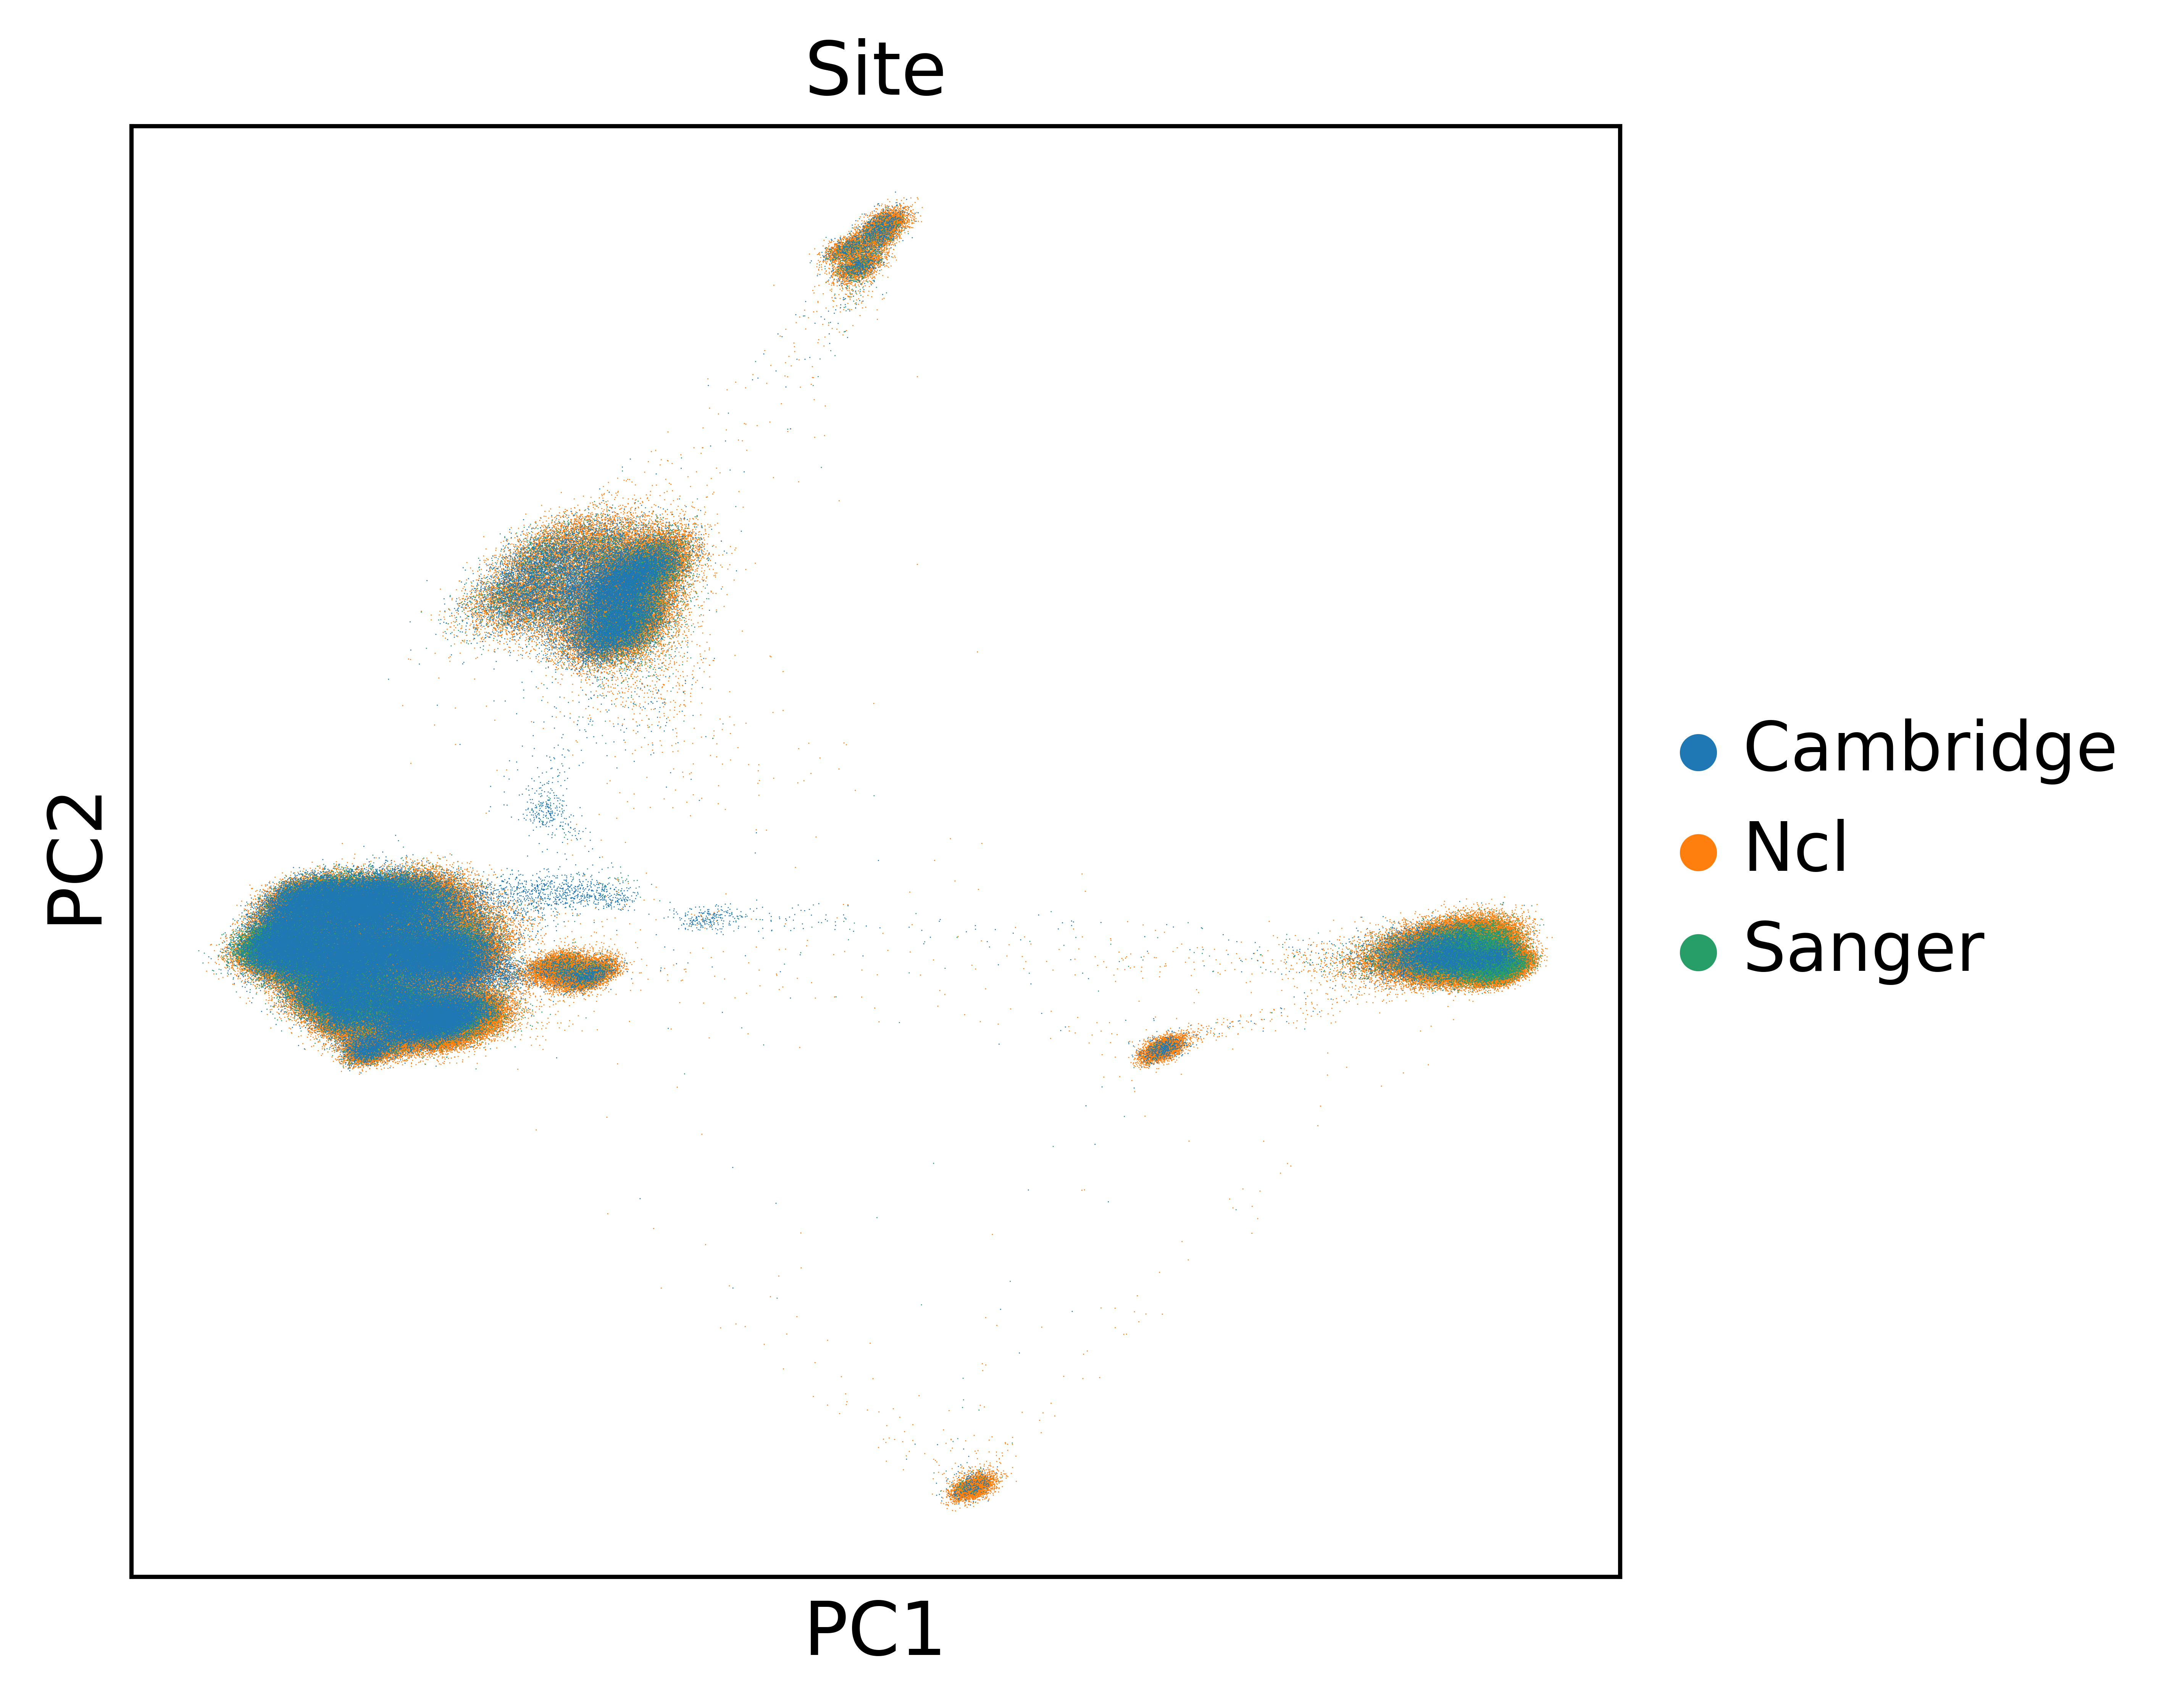

In [96]:
sc.pl.pca(adata_latent, color='Site')

In [ ]:
sc.pl.umap(adata_latent, color='Site')

In [ ]:
sc.pl.umap(adata_latent, color='Status_on_collection_day_summaru')